In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F 


In [2]:
from bigram_network_train import load_raw_data, str_encoders

In [3]:
names_lines = load_raw_data()

In [4]:
stoi, itos = str_encoders(names_lines)

In [5]:
print(len(stoi), len(itos))

27 27


### Input Output prep

In [18]:
xs, ys = [], []
for name in names_lines:
    name = '..' + name + '.'
    for st in range(len(name))[:-2]:
        x1, x2 = name[st:st+1], name[st+1:st+2]
        y = name[st+2]
        xs.append(stoi[x1]*len(stoi)+stoi[x2])
        ys.append(stoi[y])
        
xs, ys = torch.tensor(xs), torch.tensor(ys)

In [19]:
# W = torch.randn(27, 27).reshape(-1)
# print(W.shape)
# make_index = lambda a,b: a*27 + b

# def index_details(a, b):
#     idx = make_index(a, b)
#     print(f"a = {a}, b = {b}, index = {idx}, value = {W[idx]}")

# index_details(0, 0)
# index_details(26, 26)

In [20]:
randperm = torch.randperm(len(ys))
xs = xs[randperm]
ys = ys[randperm]

In [21]:
xs.shape, ys.shape

(torch.Size([228146]), torch.Size([228146]))

In [26]:
print(xs[:5])
print(xs.max())

tensor([140,  51, 225, 231,  10])
tensor(728)


In [22]:

i80 = round(len(ys)*8/10)
i90 = round(len(ys)*9/10)
i80, i90

(182517, 205331)

In [23]:
xs_train, xs_dev, xs_test = xs[:i80], xs[i80:i90], xs[i90:]
ys_train, ys_dev, ys_test = ys[:i80], ys[i80:i90], ys[i90:]
print(xs_train.shape, xs_dev.shape, xs_test.shape)
print(ys_train.shape, ys_dev.shape, ys_test.shape)

torch.Size([182517]) torch.Size([22814]) torch.Size([22815])
torch.Size([182517]) torch.Size([22814]) torch.Size([22815])


In [28]:
x_enc = F.one_hot(xs, num_classes=len(stoi)*len(stoi)).float()

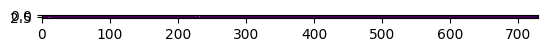

In [29]:
plt.imshow(x_enc[0:5])

In [44]:
class TrigramModelHighdim:
    
    @staticmethod
    def nll(likelihood):
        return -1*torch.log(likelihood)
    
    def __init__(self, stoi, itos) -> None:
        self.stoi = stoi
        self.itos = itos
        self.g = torch.Generator().manual_seed(1234)
        self.W = torch.randn(len(stoi)*len(stoi), len(stoi), generator=self.g, requires_grad=True)
        self.W.grad = None
        
    def encode(self, xs):
        return F.one_hot(xs, num_classes=len(self.stoi)*len(self.stoi)).float()
        
    def forward(self, xs):
        x_enc = self.encode(xs)
        logits = x_enc @ self.W
        counts = logits.exp()
        return counts/counts.sum(1, keepdim=True)
        
    def loss(self, probs, ys):
        likelihood = probs[torch.arange(len(ys)), ys]
        return self.nll(likelihood).mean()
    
    def step(self, lr):
        self.W.data += -1*lr*self.W.grad
        
    def run(self, xs, ys, num, lr):
        losses = []
        for _ in range(num):
            self.W.grad = None
            probs = self.forward(xs)
            loss = self.loss(probs, ys)
            loss.backward()
            self.step(lr)
            losses.append(loss.item())
            
        return losses

In [45]:
model = TrigramModelHighdim(stoi, itos)
losses = model.run(xs_train, ys_train, 10, 0.1)
losses[::2]

[3.737805128097534,
 3.7374939918518066,
 3.7371826171875,
 3.7368721961975098,
 3.7365622520446777]

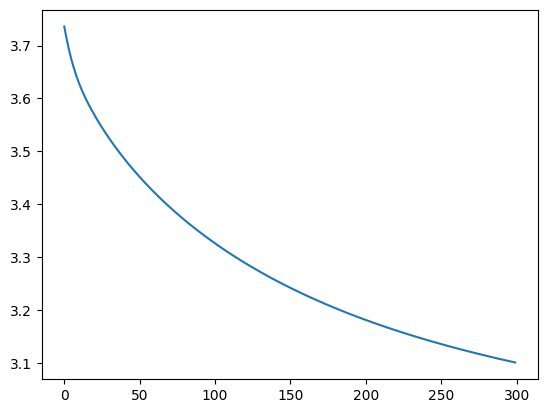

In [46]:
losses = model.run(xs_train, ys_train, 300, 10)
plt.plot(losses)

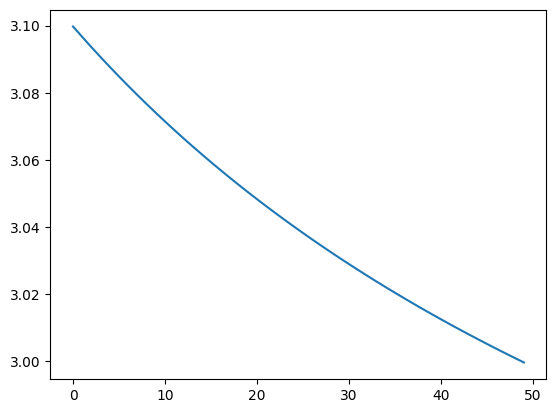

In [47]:
losses = model.run(xs_train, ys_train, 50, 50)
plt.plot(losses)

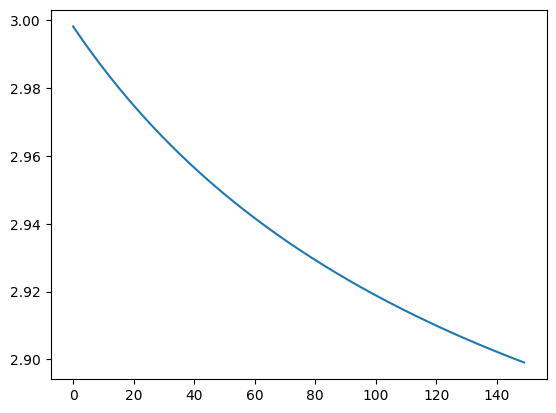

In [48]:
losses = model.run(xs_train, ys_train, 150, 50)
plt.plot(losses)

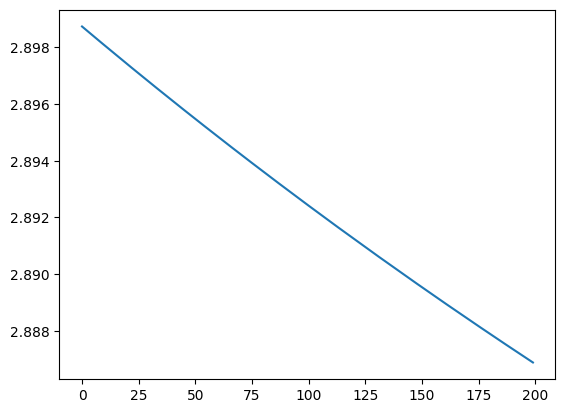

In [49]:
losses = model.run(xs_train, ys_train, 200, 10)
plt.plot(losses)

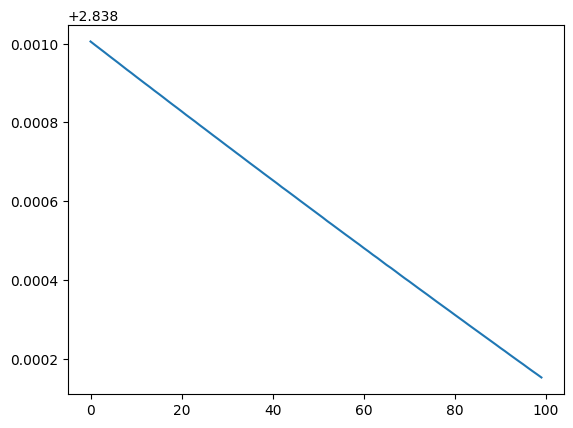

In [20]:
losses = model.run(xs_train, ys_train, 100, 1)
plt.plot(losses)

In [21]:
losses[-1]

2.83815336227417

In [24]:
print(f"train loss is {model.loss(model.forward(xs_train), ys_train)}")
print(f"dev loss is {model.loss(model.forward(xs_dev), ys_dev)}")

train loss is 2.8381447792053223
dev loss is 2.8425660133361816


In [25]:
with torch.no_grad():
    names = []
    for i in range(10):
        name = '..'
        while(True):
            input_str = name[-2:]
            xs = torch.tensor([stoi[i] for i in input_str])
            probs = model.forward(xs)
            output_char = itos[torch.multinomial(probs, 1, replacement=True, generator=model.g).item()]
            if output_char == '.':
                name = name[2:]
                break
            else:
                name += output_char
        names.append(name)
        


In [26]:
names

['miqtra',
 'enela',
 'b',
 'lra',
 'at',
 'yo',
 'uknnbjiuii',
 'n',
 'aiaaryosrkiamdni',
 'avbey']